In [ ]:
# Importing general libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# Set random seeds for reproducibility
import tensorflow as tf
np.random.seed(42)
tf.random.set_seed(42)

# Machine Learning Libraries
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, ParameterGrid
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Time Series Library
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Deep Learning Libraries
!pip install -q keras-tuner
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


In [ ]:
# Load the dataset
file_path = "/content/weather_2016_2020_daily.csv"
df = pd.read_csv(file_path, parse_dates=["Date"])


df.set_index("Date", inplace=True)

features = ['Temp_max', 'Temp_avg', 'Temp_min',
            'Hum_max', 'Hum_avg', 'Hum_min',
            'Wind_max', 'Wind_avg', 'Wind_min',
            'Press_max', 'Press_avg', 'Press_min',
            'Precipit']
df = df[features]


In [ ]:
# Create Lag Features (1 to 7 days lag for Precipit)
for lag in range(1, 8):
    df[f'Precipit_lag_{lag}'] = df['Precipit'].shift(lag)

# Create Rolling Window Features
df['Precipit_3d_avg'] = df['Precipit'].rolling(window=3).mean()
df['Precipit_7d_avg'] = df['Precipit'].rolling(window=7).mean()
df['Precipit_7d_std'] = df['Precipit'].rolling(window=7).std()

# Create Time-based Features
df['day_of_week'] = df.index.dayofweek
df['month'] = df.index.month
df['day_of_year'] = df.index.dayofyear

# Remove NaN values produced by lag and rolling windows
df.dropna(inplace=True)

In [ ]:
# Define Features and Target Variable for classical models
X = df.drop(columns=['Precipit'])
y = df['Precipit']

# Split the data (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)

# Save training columns.
X_train_columns = X_train.columns.tolist()

# Feature Scaling using StandardScaler
scaler_std = StandardScaler()
X_train_scaled = scaler_std.fit_transform(X_train)
X_test_scaled = scaler_std.transform(X_test)




Random forest regressor

Best Random Forest Parameters:  RandomForestRegressor(max_depth=20, n_estimators=200, random_state=42)

Random Forest (After Tuning):
MSE: 0.0044, MAE: 0.0252, R²: 0.9472


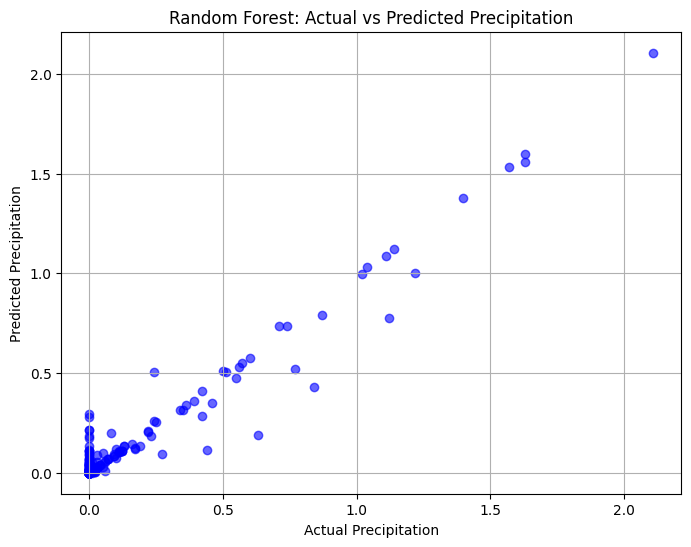

In [ ]:
# Define parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10]
}
grid_search_rf = GridSearchCV(RandomForestRegressor(random_state=42),
                              param_grid_rf, cv=5, scoring='r2', n_jobs=-1)
grid_search_rf.fit(X_train_scaled, y_train)
rf_best = grid_search_rf.best_estimator_
print(f"Best Random Forest Parameters: ", rf_best)
# Make predictions and evaluate on test set
y_pred_rf = rf_best.predict(X_test_scaled)
mse_rf = mean_squared_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("\nRandom Forest (After Tuning):")
print(f"MSE: {mse_rf:.4f}, MAE: {mae_rf:.4f}, R²: {r2_rf:.4f}")

# Scatter Plot for Actual vs Predicted (Random Forest)
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.6, color='blue')  # dots instead of line
plt.xlabel('Actual Precipitation')
plt.ylabel('Predicted Precipitation')
plt.title('Random Forest: Actual vs Predicted Precipitation')
plt.grid(True)
plt.show()


stacking regressor

Best GradientBoosting Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 150}
Stacking Regressor (After Tuning) - MSE: 0.0087, MAE: 0.0270, R²: 0.8964


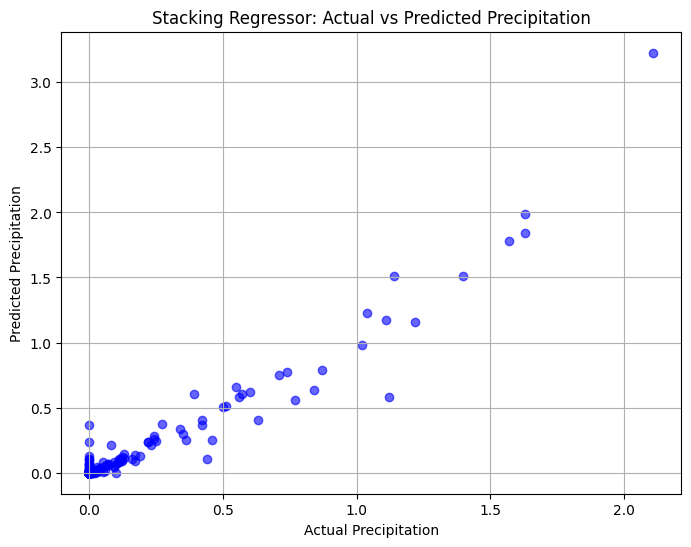

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid_gb = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

# Initialize model
gb_model = GradientBoostingRegressor(random_state=42)

# Grid Search
grid_search_gb = GridSearchCV(gb_model, param_grid_gb, cv=5, scoring='r2', n_jobs=-1)
grid_search_gb.fit(X_train_scaled, y_train)

# Best Gradient Boosting model
best_gb = grid_search_gb.best_estimator_
print("Best GradientBoosting Parameters:", grid_search_gb.best_params_)

base_models = [
    ('rf', rf_best),
    ('gb', best_gb)
]

# Stacking Regressor with a final estimator
stacking_model = StackingRegressor(estimators=base_models,
                                   final_estimator=RandomForestRegressor(n_estimators=50, random_state=42))
stacking_model.fit(X_train_scaled, y_train)

# Predictions and evaluation for stacking regressor
y_pred_stack = stacking_model.predict(X_test_scaled)
mse_stack = mean_squared_error(y_test, y_pred_stack)
mae_stack = mean_absolute_error(y_test, y_pred_stack)
r2_stack = r2_score(y_test, y_pred_stack)

# Print results
print(f"Stacking Regressor (After Tuning) - MSE: {mse_stack:.4f}, MAE: {mae_stack:.4f}, R²: {r2_stack:.4f}")

# Scatter Plot for Actual vs Predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_stack, alpha=0.6, color='blue')
plt.xlabel('Actual Precipitation')
plt.ylabel('Predicted Precipitation')
plt.title('Stacking Regressor: Actual vs Predicted Precipitation')
plt.grid(True)
plt.show()


sarimax

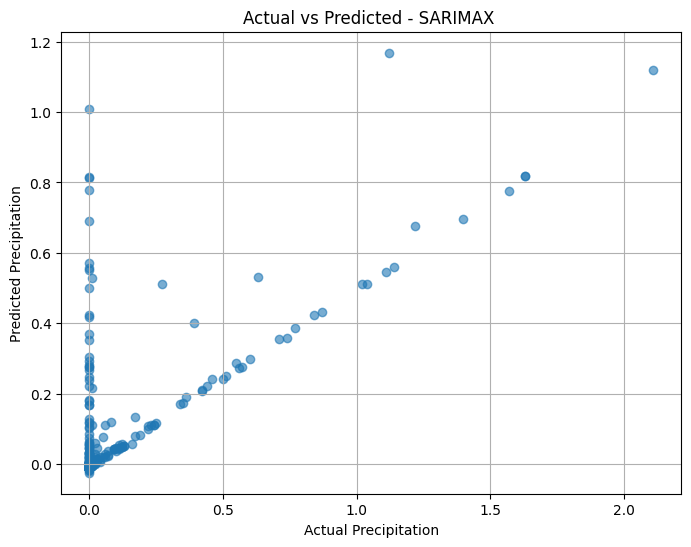

In [ ]:
from itertools import product
p = d = q = P = D = Q = [0, 3]
s = [7]
param_grid = list(product(p, d, q, P, D, Q, s))
y = df['Precipit']
exog = df[['Precipit_lag_1', 'Precipit_3d_avg', 'day_of_week']]

train_size = int(len(df) * 0.8)
y_train, y_test = y[:train_size], y[train_size:]
exog_train, exog_test = exog[:train_size], exog[train_size:]

best_score = float("inf")
best_params = None
best_model = None

for params in param_grid:
    try:
        model = SARIMAX(y_train,
                        exog=exog_train,
                        order=(params[0], params[1], params[2]),
                        seasonal_order=(params[3], params[4], params[5], params[6]),
                        enforce_stationarity=False,
                        enforce_invertibility=False)
        results = model.fit(disp=False)
        forecast = results.forecast(steps=len(y_test), exog=exog_test)
        mse = mean_squared_error(y_test, forecast)
        if mse < best_score:
            best_score = mse
            best_params = params
            best_model = results
    except:
        continue

# Evaluate final model
forecast_final = best_model.forecast(steps=len(y_test), exog=exog_test)
mse_sarimax = mean_squared_error(y_test, forecast_final)
mae_sarimax = mean_absolute_error(y_test, forecast_final)
r2_sarimax = r2_score(y_test, forecast_final)

mse_sarimax, mae_sarimax, r2_sarimax, best_params

# Scatter Plot for Actual vs Predicted (SARIMAX)
plt.figure(figsize=(8, 6))
plt.scatter(y_test, forecast_final, alpha=0.6)
plt.xlabel('Actual Precipitation')
plt.ylabel('Predicted Precipitation')
plt.title('Actual vs Predicted - SARIMAX ')
plt.grid(True)
plt.show()


LSTM

In [ ]:
!pip install -q keras-tuner
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras_tuner as kt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping

# Preprocessing - Scaling
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

# Creating sequences
def create_sequences(data, time_steps=14):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps])
        y.append(data[i + time_steps, 0])  # Assuming precipitation is the first column
    return np.array(X), np.array(y)

time_steps = 14
train_size = int(len(scaled_data) * 0.8)
train, test = scaled_data[:train_size], scaled_data[train_size:]
X_train, y_train = create_sequences(train, time_steps)
X_test, y_test = create_sequences(test, time_steps)

#  Define Model Builder
def build_model(hp):
    model = Sequential()

    model.add(LSTM(
        units=hp.Int('units1', min_value=32, max_value=128, step=32),
        return_sequences=True,
        activation='relu',
        input_shape=(X_train.shape[1], X_train.shape[2])
    ))
    model.add(Dropout(hp.Float('dropout1', 0.1, 0.5, step=0.1)))

    model.add(LSTM(
        units=hp.Int('units2', min_value=16, max_value=64, step=16),
        activation='relu'
    ))
    model.add(Dropout(hp.Float('dropout2', 0.1, 0.5, step=0.1)))

    model.add(Dense(1))

    model.compile(
        optimizer='adam',
        loss='mse'
    )

    return model

# Set up Keras Tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    overwrite=True
)

# Set up Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Start Tuning
tuner.search(X_train, y_train,
             epochs=50,
             batch_size=32,
             validation_data=(X_test, y_test),
             callbacks=[early_stopping],
             verbose=1)

# Retrieve Best Model
best_model = tuner.get_best_models(num_models=1)[0]

#  Make Predictions
y_pred = best_model.predict(X_test)

# Inverse Transform Predictions and Actual
y_test_inv = scaler.inverse_transform(
    np.concatenate([y_test.reshape(-1, 1), np.zeros((y_test.shape[0], scaled_data.shape[1]-1))], axis=1)
)[:, 0]

y_pred_inv = scaler.inverse_transform(
    np.concatenate([y_pred.reshape(-1, 1), np.zeros((y_pred.shape[0], scaled_data.shape[1]-1))], axis=1)
)[:, 0]

#  Evaluation
mse_lstm = mean_squared_error(y_test_inv, y_pred_inv)
mae_lstm = mean_absolute_error(y_test_inv, y_pred_inv)
r2_lstm = r2_score(y_test_inv, y_pred_inv)

print(f"LSTM (Keras Tuner Optimized) - MSE: {mse_lstm:.4f}, MAE: {mae_lstm:.4f}, R²: {r2_lstm:.4f}")




Trial 10 Complete [00h 00m 37s]
val_loss: 0.009561040438711643

Best val_loss So Far: 0.00948289968073368
Total elapsed time: 00h 04m 01s
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step
LSTM (Keras Tuner Optimized) - MSE: 42.5687, MAE: 5.1559, R²: 0.7406
